In [1]:
# Packages and Settings 
%matplotlib notebook
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd

## Import Data 

Generate the training data for eddy-viscosity relation in the ML-RANS framework. The two inputs features are:

$$q_1 = 50k/(50k+u_iu_i)$$

$$q_2 = k/(k+50\nu\omega)$$

The output data is:
$$5\nu_t/(5\nu_t+3k/\omega)$$

the training data is generated by equally sample 50 points in channel flow at:

$$Re_\tau=\left\{180, 395, 640, 1020\right\}$$

In [2]:
TF_inputs_data = np.genfromtxt("inputs.txt")
TF_outputs_data = np.reshape(np.genfromtxt("outputs.txt"),[-1,1])

<IPython.core.display.Javascript object>


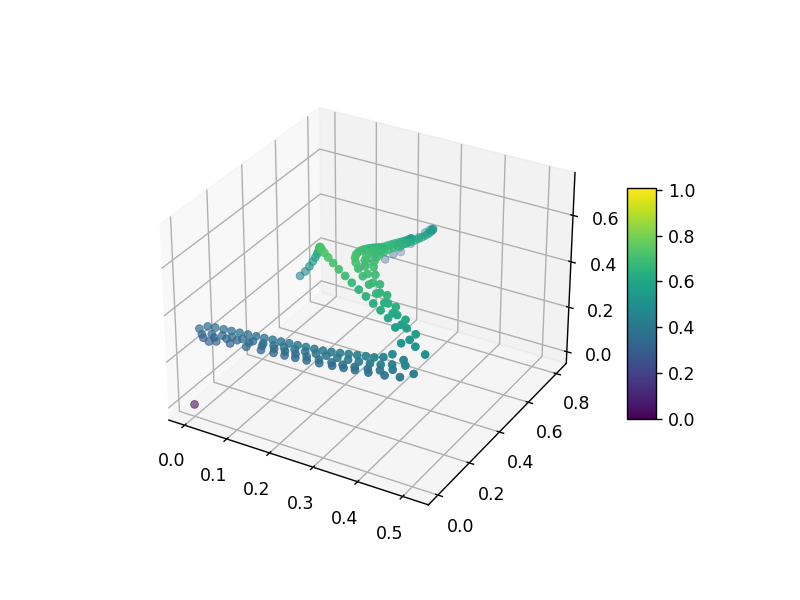

In [3]:
# visualize training data
from matplotlib import cm
from matplotlib.ticker import LinearLocator
# from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

points = ax.scatter(TF_inputs_data[:,0], TF_inputs_data[:,1], 
                    np.squeeze(TF_outputs_data),
                    c=np.squeeze(TF_outputs_data), 
                    cmap='viridis', vmin = 0, vmax = 1.01,
                    linewidth=0.5)
fig.colorbar(points,shrink=0.5, aspect=8)

## Training ML model in PyTorch

In [4]:
import torch
from torch import nn
from torch import optim

In [20]:
x_train_data = torch.FloatTensor(np.reshape(TF_inputs_data, [-1, 2]))
y_train_data = torch.FloatTensor(np.reshape(TF_outputs_data, [-1, 1]))

In [21]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, n_node=24):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(input_dim,n_node),
            nn.Tanh(),
            nn.Linear(n_node,n_node),
            nn.Tanh(),
            nn.Linear(n_node,n_node),
            nn.Tanh(),
            nn.Linear(n_node,1)
        )

    def forward(self, x):
        y = self.linear_tanh_stack(x)
        return y

model = NeuralNetwork()
# print(model)


loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
def train(model, loss_fn, optimizer, l1_reg = 4e-06, l2_reg = 6e-06):
    model.train()
    
    # Compute prediction error
    pred = model(x_train_data)
    # Losses
    MSE_loss = loss_fn(pred, y_train_data)
    l1_loss = sum(p.abs().sum() for p in model.parameters())
    l2_loss = sum(p.pow(2.0).sum() for p in model.parameters())
    reg_loss = l1_reg * l1_loss +  l2_reg * l2_loss
    loss = MSE_loss + reg_loss

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), MSE_loss.item(), reg_loss.item()

In [23]:
Loss_total, Loss_MSE, Loss_Reg = [], [], []

In [24]:
from tqdm import tqdm
epochs = 5000

for epoch in tqdm(range(epochs)):
    l_t, l_m, l_r = train(model, loss_fn, optimizer)
    
    Loss_total.append(l_t)
    Loss_MSE.append(l_m)
    Loss_Reg.append(l_r)

100%|██████████| 5000/5000 [00:10<00:00, 461.04it/s]


<IPython.core.display.Javascript object>


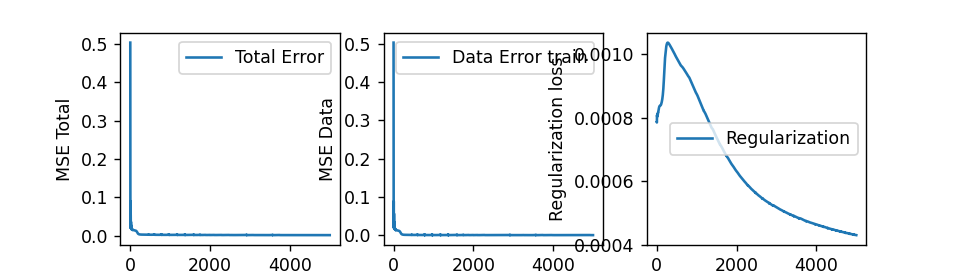

In [25]:
def plot_loss():
    Epoch_list = list(range(1, len(Loss_total)+1))
    fig, axs = plt.subplots(1,3,figsize=(7.7,2.2))
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('MSE Total')
    axs[0].plot(Epoch_list, Loss_total,label='Total Error')
    axs[0].legend()

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('MSE Data')
    axs[1].plot(Epoch_list, Loss_MSE, label='Data Error train')
    axs[1].legend()

    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Regularization loss')
    axs[2].plot(Epoch_list, Loss_Reg, label='Regularization')
    axs[2].legend()

plot_loss()

## Results

#### 2D Countours

<IPython.core.display.Javascript object>


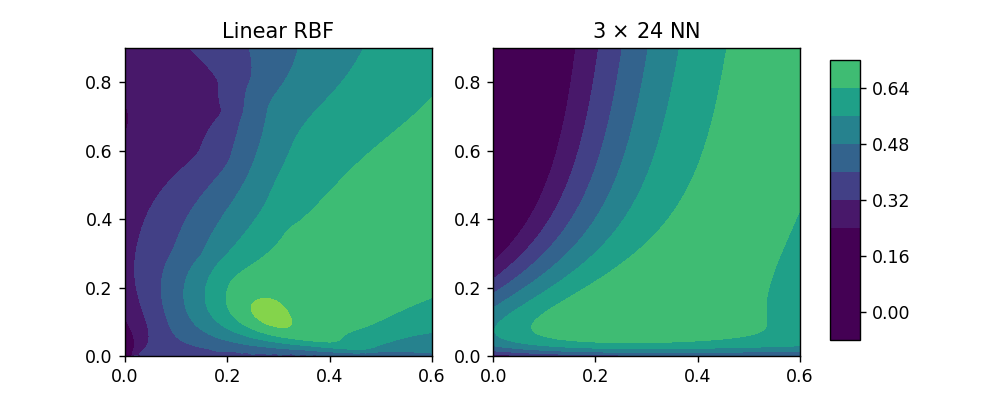

In [32]:
from scipy.interpolate import griddata
from scipy.interpolate import Rbf


model.eval()
grid_x, grid_y = np.mgrid[0:0.6:200j, 0:0.9:200j]
with torch.no_grad():
    z_pred_flat = model(torch.FloatTensor(np.transpose([grid_x.flatten(),grid_y.flatten()]))).flatten()
# z_pred_flat = model(np.transpose([grid_x.flatten(),grid_y.flatten()])).flatten()
z_pred_reg = z_pred_flat.reshape((200, 200)).numpy()

F_rbf = Rbf(TF_inputs_data[0:200,0], TF_inputs_data[0:200,1], np.squeeze(TF_outputs_data[0:200]), 
            function='linear', 
            epsilon=8, smooth=1e-3)
z_interp = F_rbf(grid_x.flatten(),grid_y.flatten()).reshape((200, 200))


fig, axs = plt.subplots(1,2,figsize=(8,3.2))
axs[0].contourf(grid_x, grid_y, z_interp, levels=10, vmin = 0.24, vmax = 0.88)

cs = axs[1].contourf(grid_x, grid_y, z_pred_reg, levels=10, vmin = 0.24, vmax = 0.88)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
fig.colorbar(cs, cax=cbar_ax)
axs[0].title.set_text("Linear RBF")
axs[1].title.set_text(r"3 $\times$ 24 NN")

<IPython.core.display.Javascript object>


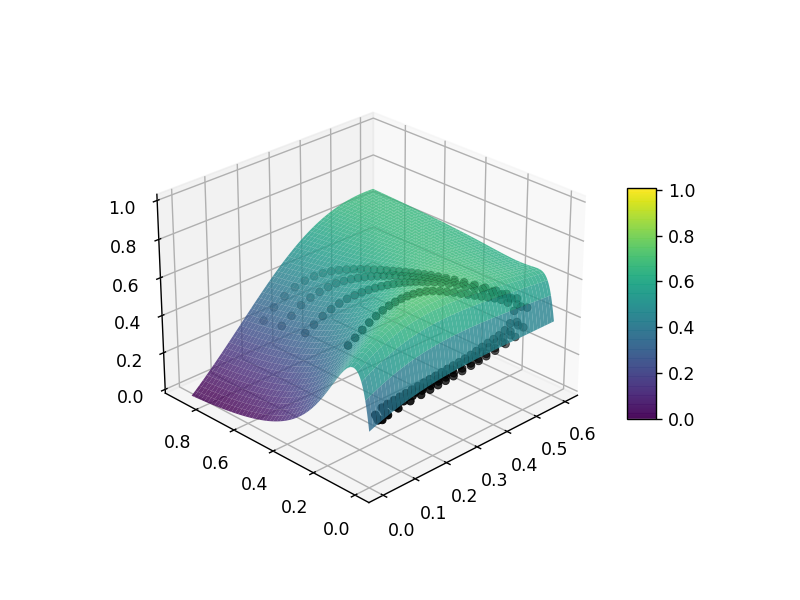

In [34]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


surf = ax.plot_surface(grid_x, grid_y, z_pred_reg,
                       cmap='viridis', edgecolor='none',
                       vmin = 0, vmax = 1.01, alpha=0.8)

points = ax.scatter(TF_inputs_data[1:,0], TF_inputs_data[1:,1], 
                    np.squeeze(TF_outputs_data[1:]),
                    c='k', 
                    cmap='viridis', vmin = 0, vmax = 1.01,
                    linewidth=0.5)


ax.set_zlim(0, 1.01)
ax.view_init(elev=26.9, azim=-134.4)

fig.colorbar(surf, shrink=0.5, aspect=8)

<IPython.core.display.Javascript object>


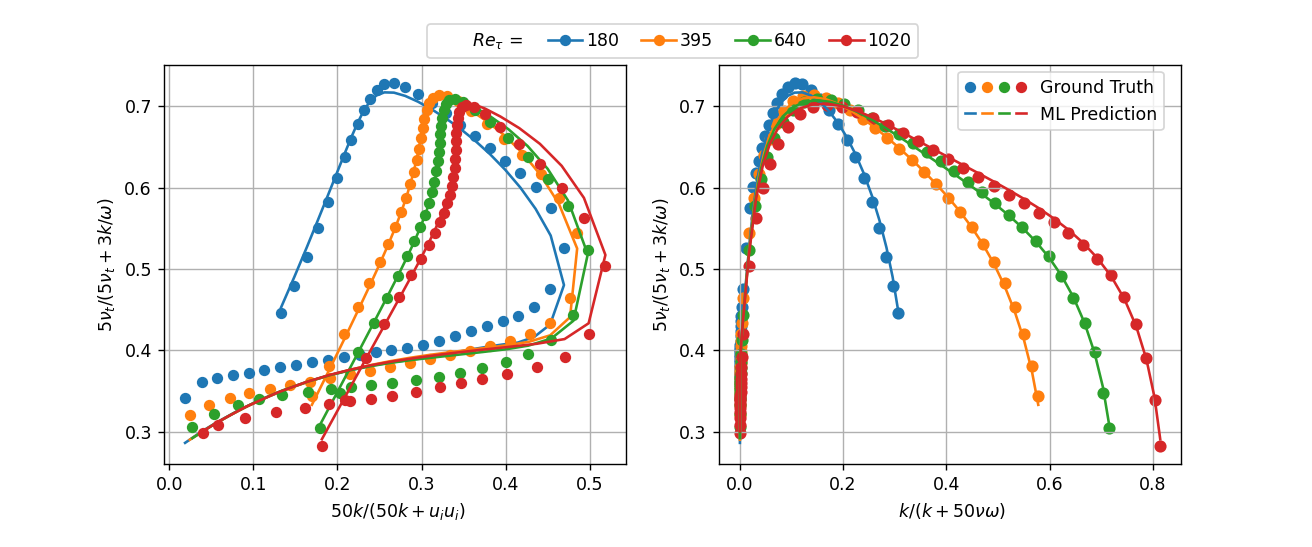

In [35]:
import matplotlib.legend_handler

with torch.no_grad():
    nutnd_pred = model(x_train_data).flatten().numpy()
# nutnd_pred = model.predict(TF_inputs_data[:,:])
fig, axs = plt.subplots(1,2,figsize=(8.4,3.5))

l_T = []
l_Ideal = []
l_ML = []

l_T.append(ax.plot([], [], ' ')[0])

axs[0].grid()
for i in range(4):
    l_T.append(ax.plot([], [],linestyle = '-',color='C'+str(i), marker='o', markeredgecolor='C'+str(i),markerfacecolor='C'+str(i), markersize=5.5,markevery=37)[0])
    l_Ideal.append(axs[0].plot(TF_inputs_data[50*i+1:50*(i+1)+1,0], TF_outputs_data[50*i+1:50*(i+1)+1],
                  color='C'+str(i),linestyle = '',marker='o', markeredgecolor='C'+str(i),markerfacecolor='C'+str(i), markersize=5.5)[0])
# for i in range(4):
    l_ML.append(axs[0].plot(TF_inputs_data[50*i+1:50*(i+1)+1,0], nutnd_pred[50*i+1:50*(i+1)+1],color='C'+str(i))[0])
    
axs[0].set_ylabel(r"$5\nu_t/(5\nu_t+3k/\omega)$")
axs[0].set_xlabel(r" $50k/(50k+u_iu_i)$")
legend1=plt.legend(handles=l_T,
           labels=[r"${Re}_\tau$ = ",'180','395','640','1020'],
           ncol=6,
           borderaxespad=0.01,
           handletextpad=0.2,
           columnspacing=1.3,
           loc='center',bbox_to_anchor=(-0.1,1.06))

axs[1].grid()
for i in range(4):
    axs[1].scatter(TF_inputs_data[50*i+1:50*(i+1)+1,1], TF_outputs_data[50*i+1:50*(i+1)+1])
for i in range(4):
    axs[1].plot(TF_inputs_data[50*i+1:50*(i+1)+1,1], nutnd_pred[50*i+1:50*(i+1)+1])

axs[1].set_ylabel(r"$5\nu_t/(5\nu_t+3k/\omega)$")
axs[1].set_xlabel(r" $k/(k+50\nu\omega)$")

handles = [(l_Ideal[0],l_Ideal[1],l_Ideal[2],l_Ideal[3]), (l_ML[0],l_ML[1],l_ML[2],l_ML[3])]
labels = ['Ground Truth','ML Prediction']
legend2=plt.legend(handles=handles,labels=labels,ncol=1,loc='center',
                  bbox_to_anchor=(0.74,0.91),
                  handlelength = 3.5,
                  handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})
plt.gca().add_artist(legend1)

plt.subplots_adjust(wspace=0.2, hspace=0.08, bottom=0.15)

## Save the model into onnx

In [36]:
script_module = torch.jit.script(model)
output_script = script_module(x_train_data)

input_names = ['input']
output_names = ['output']

dynamic_axes = {
  'input': {0 : 'batch_size'},
  'output': {0 : 'batch_size'}
}

torch.onnx.export(script_module,             # model being run
                  x_train_data,              # model input (or a tuple for multiple inputs)
                  "eddyviscosity.onnx",         # where to save the model (can be a file or file-like object)
                  verbose=True,              # Print informations
                  export_params=True,        # store the trained parameter weights inside the model file
                  # opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=input_names,   # the model's input names
                  output_names=output_names, # the model's output names
                  dynamic_axes=dynamic_axes) # the model's dynamic axes

graph(%input : Float(*, 2, strides=[2, 1], requires_grad=0, device=cpu),
      %linear_tanh_stack.0.weight : Float(24, 2, strides=[2, 1], requires_grad=0, device=cpu),
      %linear_tanh_stack.0.bias : Float(24, strides=[1], requires_grad=0, device=cpu),
      %linear_tanh_stack.2.weight : Float(24, 24, strides=[24, 1], requires_grad=0, device=cpu),
      %linear_tanh_stack.2.bias : Float(24, strides=[1], requires_grad=0, device=cpu),
      %linear_tanh_stack.4.weight : Float(24, 24, strides=[24, 1], requires_grad=0, device=cpu),
      %linear_tanh_stack.4.bias : Float(24, strides=[1], requires_grad=0, device=cpu),
      %linear_tanh_stack.6.weight : Float(1, 24, strides=[24, 1], requires_grad=0, device=cpu),
      %linear_tanh_stack.6.bias : Float(1, strides=[1], requires_grad=0, device=cpu)):
  %9 : Float(*, 24, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%input, %linear_tanh_stack.0.weight, %linear_tanh_stack.0.bias) # /home/lws/Codespace/VirtualEnv/TF2/lib/python3.6/site-